## Object Detection Pipeline on UCS using Darknet & YOLO

This notebook focuses on implementing object detection as a Kubeflow pipeline on Cisco UCS by using Darknet which is a open-source neural network framework, YOLO (You Look Only Once) which is a real-time object detection system.

## Clone Cisco Kubeflow Starter pack repository

In [1]:
BRANCH_NAME="dev" #Provide git branch "master" or "dev"
! git clone -b $BRANCH_NAME https://github.com/CiscoAI/cisco-kubeflow-starter-pack.git

Cloning into 'cisco-kubeflow-starter-pack'...
remote: Enumerating objects: 383, done.
remote: Counting objects: 100% (383/383), done.
remote: Compressing objects: 100% (261/261), done.
remote: Total 4951 (delta 125), reused 307 (delta 73), pack-reused 4568
Receiving objects: 100% (4951/4951), 23.61 MiB | 16.17 MiB/s, done.
Resolving deltas: 100% (1854/1854), done.


## Clone tensorflow-yolov4-tflite repository

This repository contains user-defined packages to be used for the purpose of post-processing the predicted output data.

In [2]:
!git clone https://github.com/hunglc007/tensorflow-yolov4-tflite.git

Cloning into 'tensorflow-yolov4-tflite'...
remote: Enumerating objects: 780, done.
remote: Total 780 (delta 0), reused 0 (delta 0), pack-reused 780
Receiving objects: 100% (780/780), 197.64 MiB | 47.71 MiB/s, done.
Resolving deltas: 100% (371/371), done.


## Install required packages

In [3]:
!pip install kfp opencv-python==4.1.1.26 pillow tensorflow==2.3.0rc0 easydict --user

     |████████████████████████████████| 116 kB 19.2 MB/s eta 0:00:01
     |████████████████████████████████| 28.7 MB 10.6 MB/s eta 0:00:01��█████████████▊               | 14.9 MB 10.6 MB/s eta 0:00:02
     |████████████████████████████████| 2.2 MB 108.0 MB/s eta 0:00:01
     |███████████████████████████▌    | 275.0 MB 170.7 MB/s eta 0:00:01

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 320.3 MB 12 kB/s 
     |████████████████████████████████| 54 kB 5.4 MB/s  eta 0:00:01
     |████████████████████████████████| 51 kB 2.5 MB/s  eta 0:00:01
     |████████████████████████████████| 82 kB 2.4 MB/s  eta 0:00:01
     |████████████████████████████████| 42 kB 6.1 MB/s  eta 0:00:01
     |████████████████████████████████| 459 kB 123.2 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 5.7 MB/s eta 0:00:01
     |████████████████████████████████| 779 kB 134.2 MB/s eta 0:00:01
  Created wheel for kfp: filename=kfp-1.0.0-py3-none-any.whl size=160799 sha256=fea5c33bb481f1e60ef27c629b0d0cd5be96f91ca8b0f91888d7444f09c64a38
  Stored in directory: /home/jovyan/.cache/pip/wheels/a1/4d/1d/532b25d0ea5bf28d352c8973b8ce9b1d7f8f5220b236af1c62
  Created wheel for easydict: filename=easydict-1.9-py3-none-any.whl size=5672 sha256=2f251c3a108735ad77db341a1f0a59fcbb4b2704391366556f105a90a42b7bd2
  Stored in directory: /home/jovyan/.cache/pip/wheel

## Restart kernel

In [ ]:
from IPython.display import display_html
display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)

## Import libraries

In [1]:
import os
import json
import cv2
import time
import yaml
import calendar
import requests
import logging
import numpy as np
from PIL import Image

#Kubeflow
import kfp
from kfp.aws import use_aws_secret
import kfp.compiler as compiler

#Kubernetes
from kubernetes import client

#Tensorflow
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
%cd

/home/jovyan


## Load pipeline components

Declare the paths of respective YAML configuration files of each of the pipeline components, in order to load each component into a variable for pipeline execution. 

In [2]:
path='cisco-kubeflow-starter-pack/apps/computer-vision/object-detection/onprem/pipeline/components/v2/'
component_root_dwn= path+'download/'
component_root_train= path+'train/'
component_root_convert=path+'conversion/'
component_root_kfserving=path+'kfserving/'

download_op = kfp.components.load_component_from_file(os.path.join(component_root_dwn, 'component.yaml'))
train_op = kfp.components.load_component_from_file(os.path.join(component_root_train, 'component.yaml'))
convert_op=kfp.components.load_component_from_file(os.path.join(component_root_convert, 'component.yaml'))
kfserving_op = kfp.components.load_component_from_file(os.path.join(component_root_kfserving, 'component.yaml'))

## Define volume claim & volume mount for storage during pipeline execution

Persistent volume claim & volume mount is created for the purpose of storing entities such as Dataset, model files, etc, and to share the stored resources between the various components of the pipeline during it's execution. 

In [3]:
nfs_pvc = client.V1PersistentVolumeClaimVolumeSource(claim_name='nfs')
nfs_volume = client.V1Volume(name='nfs', persistent_volume_claim=nfs_pvc)
nfs_volume_mount = client.V1VolumeMount(mount_path='/mnt/', name='nfs')

## Define pipeline function

In [4]:
def object_detection_pipeline(
    s3_path="s3://darknet-datasets",  # AWS S3 bucket URL. Ex: s3://<bucket-name>/
    nfs_path="/mnt/object_detection", # Storage path of NFS volume mount 
    output="model/001",               # Folder path for storing the trained model
    input_size="100",                 # Dimension of input image 
    model="yolov3",                   # Type of pre-trained model used (yolov3/yolov4)
    default_model_uri=" ",            # Trained model absolute path Ex: pvc://nfs/object_detection/model/  
    namespace='kubeflow',             # Namespace on which trained model is to be deployed for prediction
    inferenceservice_name="",         # Name of inference service and model name 
    inferenceservice_custom_image="", # Inference service custom model image name
    
):
    #Download component
    dwn_task = download_op(nfs_path=nfs_path, s3_path=s3_path).apply(use_aws_secret(secret_name='aws-secret', aws_access_key_id_name='AWS_ACCESS_KEY_ID', aws_secret_access_key_name='AWS_SECRET_ACCESS_KEY'))
    dwn_task.add_volume(nfs_volume)
    dwn_task.add_volume_mount(nfs_volume_mount) 
    
    #Train component 
    train_task = train_op(nfs_path=nfs_path, 
                          cfg_data="voc.data",                # Config file containing file name specifications of train, test and validate datasets
                          cfg_file="yolov3-voc.cfg",          # Config file containing hyperparameters declarations Ex: yolov3.cfg / yolov4.cfg
                          weights="yolov3-voc_50176.weights", # Pre-trained weights for VOC dataset
                          gpus="0,1,2,3")                     # Number of GPUs to run training Ex: If you need 6 GPUs, mention
                                                              # gpus='0,1,2,3,4,5' 
    train_task.add_volume(nfs_volume)
    train_task.add_volume_mount(nfs_volume_mount).set_gpu_limit(4)   #Maximum GPUs to be used for training
    train_task.after(dwn_task)
    
    #Model conversion component
    conversion_task=convert_op(push_to_s3="true",  # Inputs: true / false
                               nfs_path=nfs_path,
                               s3_path=s3_path,
                               input_size=input_size,
                               output=output
                               ).apply(use_aws_secret(secret_name='aws-secret', aws_access_key_id_name='AWS_ACCESS_KEY_ID', aws_secret_access_key_name='AWS_SECRET_ACCESS_KEY'))
    conversion_task.add_volume(nfs_volume)
    conversion_task.add_volume_mount(nfs_volume_mount)
    conversion_task.after(train_task)
    
    #KFserving component
    kfserving = kfserving_op(inferenceservice_name=inferenceservice_name,
                            storage_uri=default_model_uri,
                            image=inferenceservice_custom_image,
                            namespace=namespace).set_image_pull_policy('Always')
    kfserving.add_volume(nfs_volume)
    kfserving.add_volume_mount(nfs_volume_mount)
    kfserving.after(conversion_task)

## Compile pipeline function

Compile the pipeline function to create a tar ball for the pipeline.

In [5]:
# Compile pipeline
try:
    compiler.Compiler().compile(object_detection_pipeline, 'object-detection.tar.gz')
except RuntimeError as err:
    logging.debug(err)
    logging.info("Argo workflow failed validation check but it can still be used to run experiments.")

## Create pipeline experiment

In [6]:
kp_client = kfp.Client()
EXPERIMENT_NAME = 'Object Detection'
experiment = kp_client.create_experiment(name=EXPERIMENT_NAME)

## Initialize pipeline parameters & run pipeline

In [7]:
#Pipeline parameters
timestamp = str(calendar.timegm(time.gmtime()))
nfs_path="/mnt/object_detection"
output="model/001"
input_size=416
model="yolov3"
tiny=False
default_model_uri="pvc://nfs/{0}/{1}".format(nfs_path.split('/')[2],output.split("/")[0])
inferenceservice_custom_image="docker.io/samba07/object-detection-model-server:0.1"
inferenceservice_name="object-detection-%s"%timestamp

# Execute pipeline
run = kp_client.run_pipeline(experiment.id, 'object-detection', 'object-detection.tar.gz', 
                          params={"nfs_path":nfs_path,
                                  "output":output,
                                  "inferenceservice_custom_image": inferenceservice_custom_image,
                                  "inferenceservice_name":inferenceservice_name,
                                  "default_model_uri":default_model_uri,
                                  "input_size":input_size})

## Run a prediction
Before running a prediction, make sure that pipeline run is completed in the dashboard.

In [8]:
!kubectl get inferenceservice $inferenceservice_name -n kubeflow

NAME                          URL                                                                                             READY   DEFAULT TRAFFIC   CANARY TRAFFIC   AGE
object-detection-1599046678   http://object-detection-1599046678.kubeflow.example.com/v1/models/object-detection-1599046678   True    100                                2m17s


#### Note:
Wait for inference service READY="True"

In [9]:
CLUSTER='ucs' #where your cluster is running :'gcp' or 'ucs'

## Get cluster & inference details

Get Ingress IP, Port and Inferenceservice host name to be used for prediction

In [10]:
%%bash -s "$CLUSTER" "$inferenceservice_name" --out NODE_INFERENCE
if [ $1 = "ucs" ]
then
    echo "$(kubectl get node -o=jsonpath='{.items[0].status.addresses[0].address}')"
else
    echo "$(kubectl get node -o=jsonpath='{.items[0].status.addresses[1].address}')"
fi

INGRESS_GATEWAY="istio-ingressgateway"
echo "$(kubectl -n istio-system get service $INGRESS_GATEWAY -o jsonpath='{.spec.ports[1].nodePort}')"

echo "$(kubectl get inferenceservice $2 -n kubeflow -o jsonpath='{.status.url}' | cut -d "/" -f 3)"

### Data preprocessing & prediction

* Define functions for preprocessing data & predicting object detected image data.
* Predicted output is post-processed using functionalities to display predicted image.

In [11]:
%cd tensorflow-yolov4-tflite/

#Import user-defined packages
from core.yolov4 import filter_boxes
import core.utils as utils

#Client data preprocess function
def preprocess(image_path):
    
    config = ConfigProto()
    config.gpu_options.allow_growth = True
    session = InteractiveSession(config=config)
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    image_data = cv2.resize(original_image, (int(input_size), int(input_size)))
    image_data = image_data / 255.
    images_data = []
    for i in range(1):
        images_data.append(image_data)
    images_data = np.asarray(images_data).astype(np.float32)
    return original_image, images_data

# Function to predict object detected image data
def predict(original_image, image_data):
    headers = {"Host": NODE_INFERENCE.split('\n')[2]}
    data={"instances":image_data.tolist()}
    url = "http://%s:%s/v1/models/%s:predict"%(NODE_INFERENCE.split("\n")[0],NODE_INFERENCE.split("\n")[1], inferenceservice_name)
    response=requests.post(url, data=json.dumps(data), headers=headers)
    pred=response.json()["predictions"]
    
    #Post-process predicted output
    if model == 'yolov3' and tiny == True:
        boxes, pred_conf = filter_boxes(pred[1], pred[0], score_threshold=0.25, input_shape=tf.constant([input_size, input_size]))
    else:
        boxes, pred_conf = filter_boxes(pred[0], pred[1], score_threshold=0.25, input_shape=tf.constant([input_size, input_size]))
    boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
        boxes=tf.reshape(boxes, (tf.shape(boxes)[0], -1, 1, 4)),
        scores=tf.reshape(pred_conf, (tf.shape(pred_conf)[0], -1, tf.shape(pred_conf)[-1])),
        max_output_size_per_class=50,
        max_total_size=50,
        iou_threshold=0.45,
        score_threshold=0.25
        )
    pred_bbox = [boxes.numpy(), scores.numpy(), classes.numpy(), valid_detections.numpy()]
    image = utils.draw_bbox(original_image, pred_bbox)
    image = Image.fromarray(image.astype(np.uint8))
    return image

/home/jovyan/tensorflow-yolov4-tflite


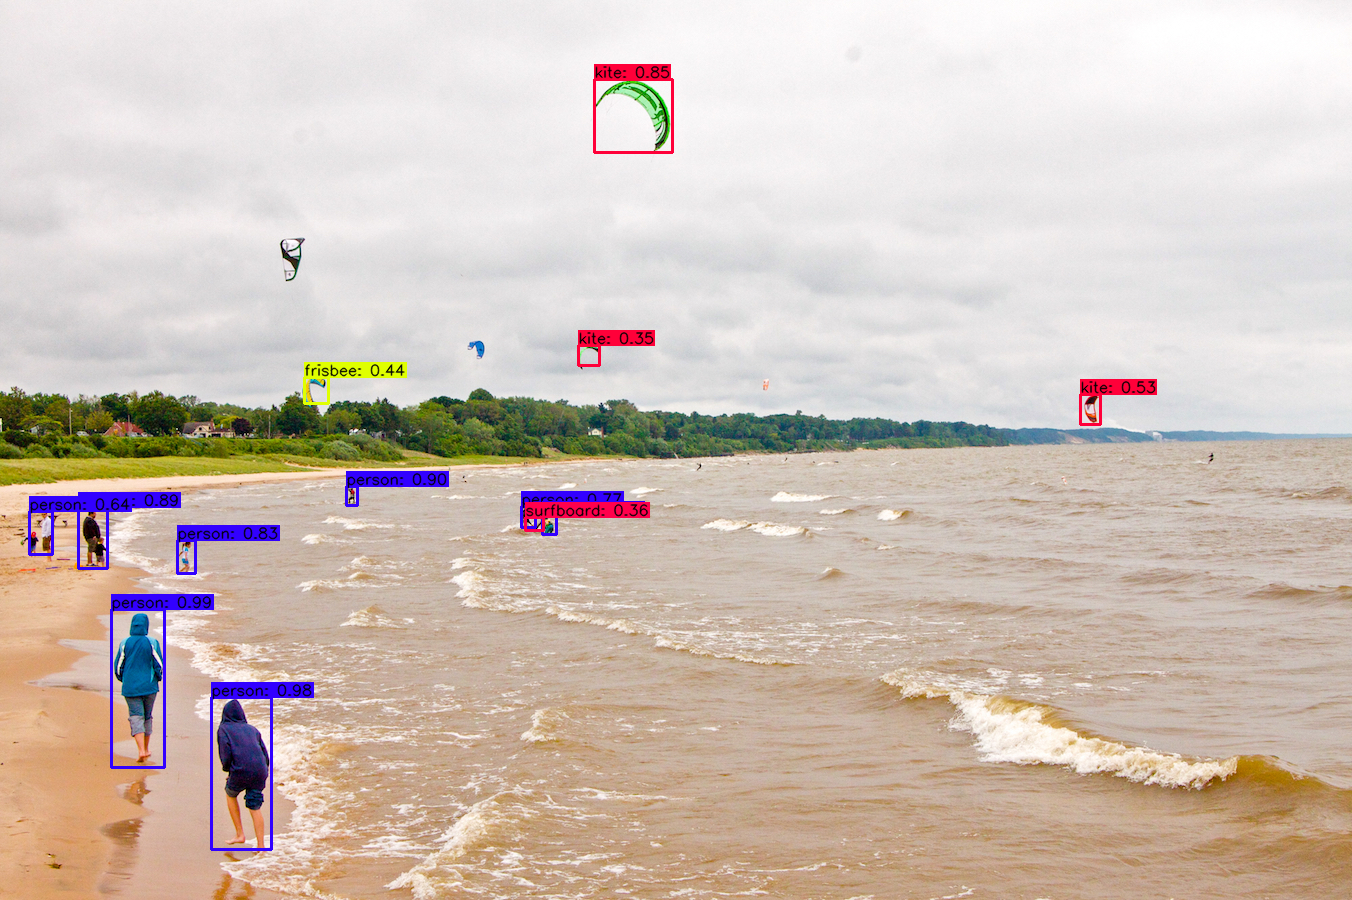

In [12]:
#Call client data preprocess function
org_img, img_data=preprocess("./data/kite.jpg")

#Call predict function
predict(original_image=org_img, image_data=img_data)

## Clean up

Clean up deployed inference service

In [13]:
%cd
!kubectl delete inferenceservice $inferenceservice_name -n kubeflow

/home/jovyan
inferenceservice.serving.kubeflow.org "object-detection-1599046678" deleted
